In [20]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["OMP_NUM_THREADS"] = '1'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='D2coding')
mpl.rc('axes', unicode_minus=False)
sns.set(font='D2coding', rc={'axes.unicode_minus':False}, style='darkgrid')
plt.rc('figure', figsize=(10, 8))

# 2018년 국내 프로야구 선수 연봉 예측

## 데이터 불러오기

In [3]:
batter = pd.read_csv('C:/k_digital/source/data/batter_stats_2017.csv')
picher = pd.read_csv('C:/k_digital/source/data/picher_stats_2017.csv')

### 데이터 기본정보

In [6]:
picher.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   선수명       152 non-null    object 
 1   팀명        152 non-null    object 
 2   승         152 non-null    int64  
 3   패         152 non-null    int64  
 4   세         152 non-null    int64  
 5   홀드        152 non-null    int64  
 6   블론        152 non-null    int64  
 7   경기        152 non-null    int64  
 8   선발        152 non-null    int64  
 9   이닝        152 non-null    float64
 10  삼진/9      152 non-null    float64
 11  볼넷/9      152 non-null    float64
 12  홈런/9      152 non-null    float64
 13  BABIP     152 non-null    float64
 14  LOB%      152 non-null    float64
 15  ERA       152 non-null    float64
 16  RA9-WAR   152 non-null    float64
 17  FIP       152 non-null    float64
 18  kFIP      152 non-null    float64
 19  WAR       152 non-null    float64
 20  연봉(2018)  152 non-null    int64 

In [7]:
picher.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [9]:
picher.shape

(152, 22)

In [10]:
picher['연봉(2018)'].describe()

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

<AxesSubplot:>

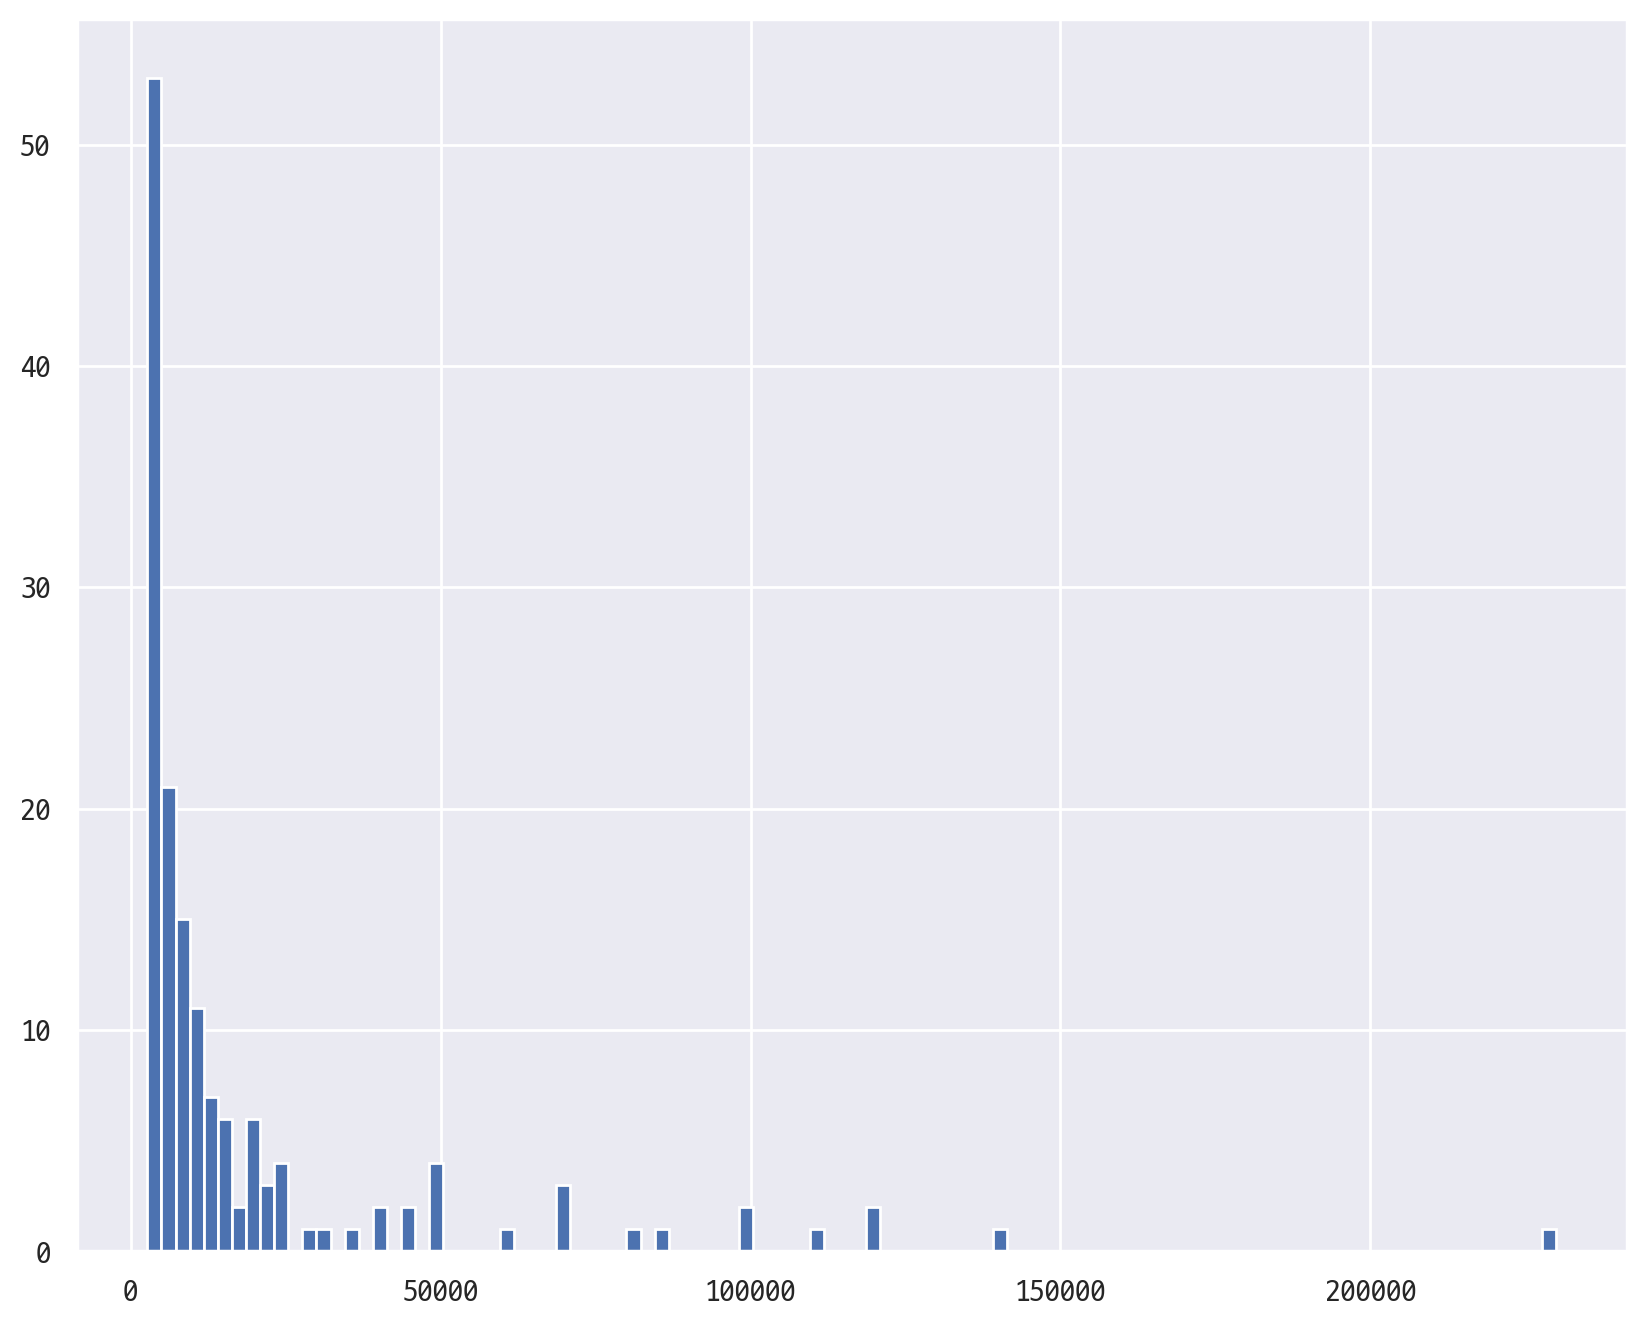

In [22]:
picher['연봉(2018)'].hist(bins=100)

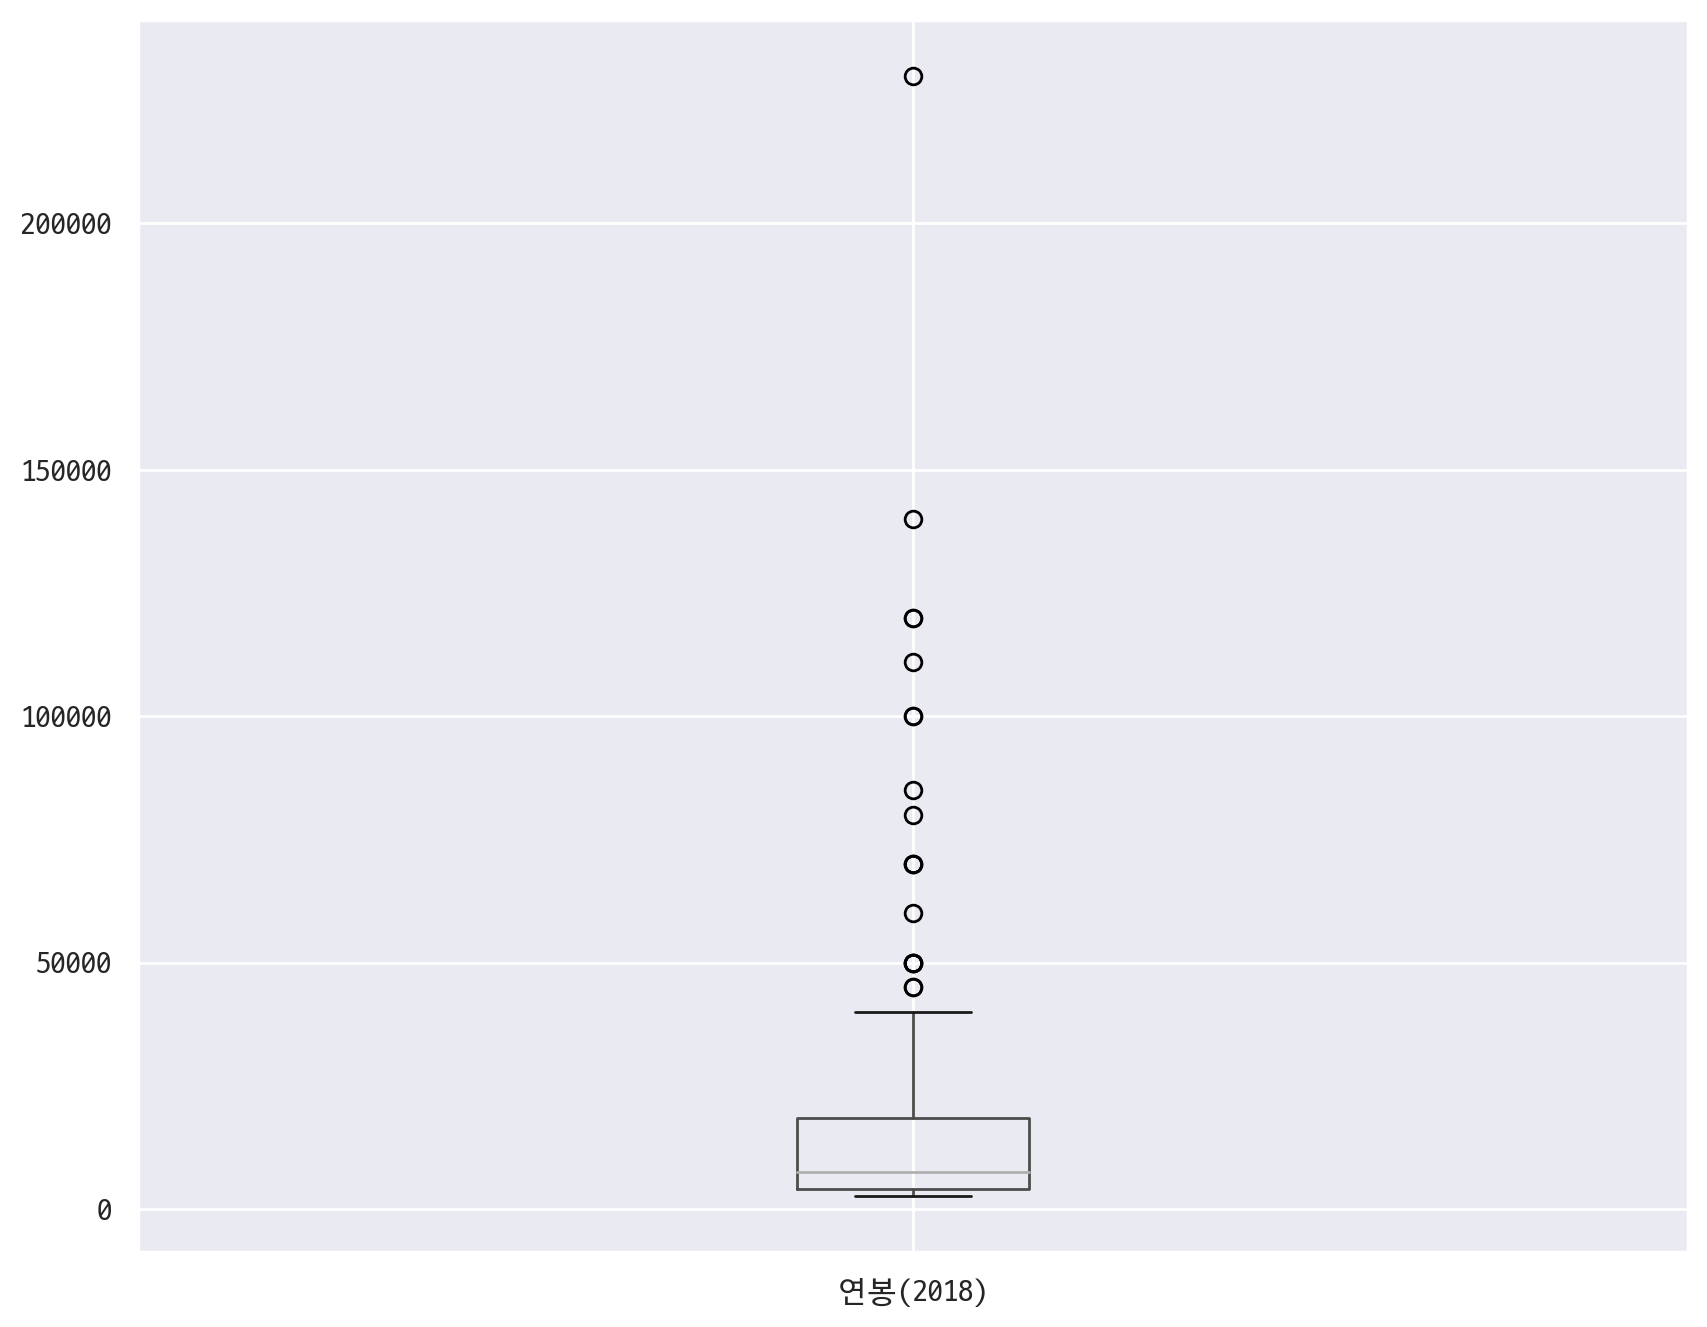

In [21]:
picher.boxplot(column='연봉(2018)')
plt.show()

## 회귀 분석에 사용할 피처 탐색

In [26]:
picher.columns

Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

In [33]:
picher_df = picher.drop(['선수명', '팀명'], axis=1)
len(picher_df.columns)

20

In [38]:
def plot_hist(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    for i in range(len(picher_df.columns)):
        ax = fig.add_subplot(5, 5, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
        plt.tight_layout()
    plt.show()

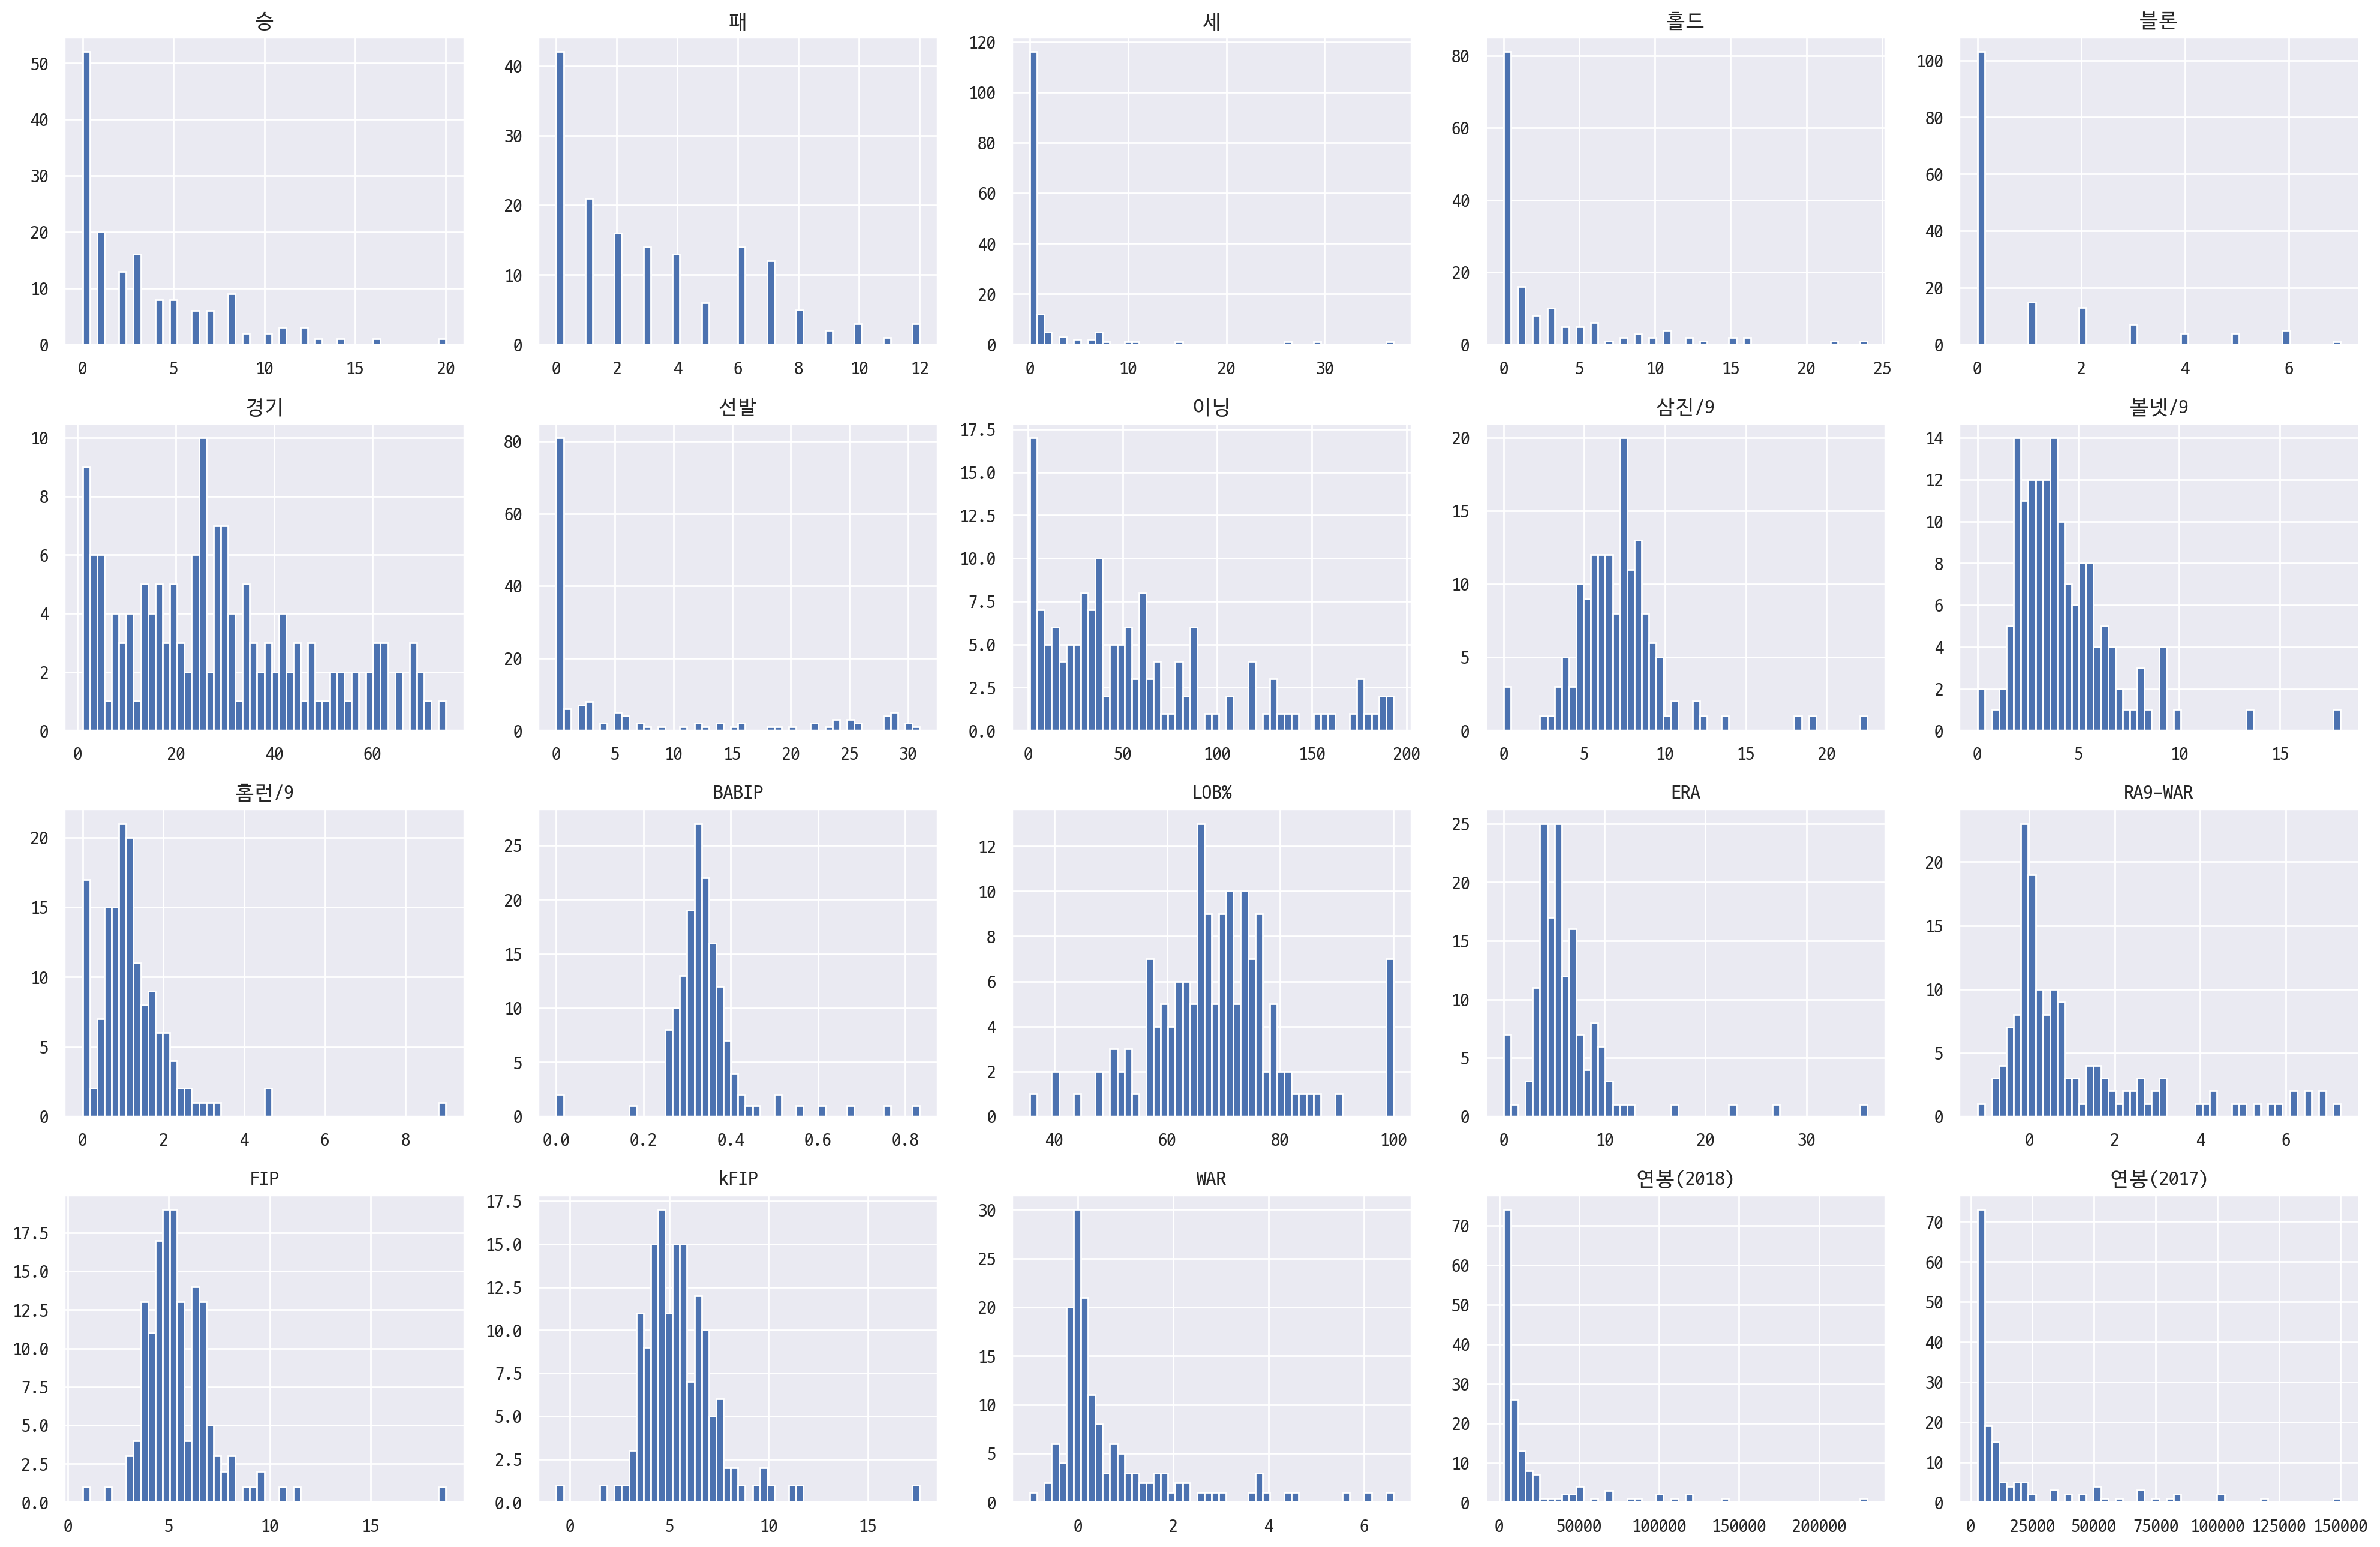

In [39]:
plot_hist(picher_df)

## 전처리 : 피처 스케일링
- 피처 스케일링 : 피처들간의 단위를 맞추는 작업
- StandardScaler : 표준화(평균=0, 표준편차=1)
- 0에서 1사이의 값으로 단위를 맞춤

In [40]:
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)

    return df

In [42]:
scale_columns = ['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
                 '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP',
                 'kFIP', 'WAR', '연봉(2017)']
picher_df = standard_scaling(picher, scale_columns)

In [43]:
picher_df = picher_df.rename(columns={'연봉(2018)': 'y'})
picher_df.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705


### 피처 스케일링 : 더미 or 원-핫 인코딩
- 문자 또는 범주형 데이터를 정형화된 데이터(0과 1)로 변형

In [44]:
team_encoding = pd.get_dummies(picher_df['팀명'])
# 기존 컬럼 제거
picher_df = picher_df.drop('팀명', axis=1)
picher_df = picher_df.join(team_encoding)

In [45]:
team_encoding.head()

,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


In [46]:
picher_df.head()

,선수명,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,...,연봉(2017),KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,켈리,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,0.672099,...,2.734705,0,0,0,0,1,0,0,0,0
1,소사,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,0.134531,...,1.337303,0,0,1,0,0,0,0,0,0
2,양현종,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,0.109775,...,5.329881,1,0,0,0,0,0,0,0,0
3,차우찬,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,0.350266,...,3.333592,0,0,1,0,0,0,0,0,0
4,레일리,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,0.155751,...,2.734705,0,0,0,0,0,0,1,0,0


In [47]:
# 성능 평가 함수
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MAE, RMSE
def evaluate_rger(y, pred):
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    print(f'MAE : {mae:.3f}, RMSE : {rmse:.3f}')

## 선형 회귀

### 기본 예측/평가

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = picher_df[picher_df.columns.difference(['선수명', 'y'])]
y = picher_df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

evaluate_rger(y_test, pred)

MAE : 6208.836, RMSE : 8476.013


In [50]:
import statsmodels.api as sm

# 상수항
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     47.11
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           5.14e-43
Time:                        10:42:53   Log-Likelihood:                -1267.7
No. Observations:                 121   AIC:                             2591.
Df Residuals:                      93   BIC:                             2670.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.68e+04    838.030     20.052      0.000    1.51e+04    1.85e+04
BABIP      -1278.3610   1490.604     -0.858      0.393   -4238.404    1681.682
ERA          -41.4437   2834.935     -0.015      0.988   -5671.062    5588.174
FIP         2.501e+04   1.02e+05      0.245      0.807   -1.78e+05    2.28e+05
KIA         2628.8280   2794.476      0.941      0.349   -2920.447    8178.103
KT          4886.8115   2541.869      1.923      0.058    -160.836    9934.459
LG          3312.8292   2603.168      1.273      0.206   -1856.546    8482.205
LOB%        -150.2946   1954.733     -0.077      0.939   -4032.008    3731.418
NC          1922.6924   3144.811      0.611      0.542   -4322.279    8167.663
RA9-WAR     -733.9182   3677.296     -0.200      0.842   -8036.300    6568.463
SK          2606.5787   2781.818      0.937      0.351   -2917.560    8130.717
WAR         1.185e+04   3150.048      3.761      0.000    5592.994    1.81e+04
kFIP       -2.296e+04   8.69e+04     -0.264      0.792   -1.95e+05     1.5e+05
경기         -2525.3807   3415.415     -0.739      0.462   -9307.719    4256.957
두산         -1847.9942   3319.425     -0.557      0.579   -8439.715    4743.727
롯데           171.1928   2991.209      0.057      0.954   -5768.756    6111.142
볼넷/9         865.4701   6502.041      0.133      0.894    -1.2e+04    1.38e+04
블론           139.3558   1498.117      0.093      0.926   -2835.607    3114.319
삼성           -23.6890   2596.250     -0.009      0.993   -5179.327    5131.948
삼진/9       -3376.4964   8305.085     -0.407      0.685   -1.99e+04    1.31e+04
선발         -5592.6158   5915.457     -0.945      0.347   -1.73e+04    6154.310
세           -134.3455   1497.022     -0.090      0.929   -3107.135    2838.444
승           7136.8706   2594.163      2.751      0.007    1985.378    1.23e+04
연봉(2017)    2.147e+04   1491.142     14.396      0.000    1.85e+04    2.44e+04
이닝           673.9514   7378.595      0.091      0.927    -1.4e+04    1.53e+04
패          -1989.4238   2325.044     -0.856      0.394   -6606.501    2627.653
한화          3146.8396   2884.872      1.091      0.278   -2581.945    8875.625
홀드          -275.2068   1747.739     -0.157      0.875   -3745.871    3195.457
홈런/9       -2215.8740   1.76e+04     -0.126      0.900   -3.72e+04    3.28e+04
==============================================================================
Omnibus:                       29.481   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.748
Skew:                          -0.103   Prob(JB):                     1.00e-69
Kurtosis:                      10.936   Cond. No.                     2.76e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

## 피처들의 영향력을 파악하기 위한 시각화 - summary 의 params

[Text(0, 0, 'const'),
 Text(1, 0, 'BABIP'),
 Text(2, 0, 'ERA'),
 Text(3, 0, 'FIP'),
 Text(4, 0, 'KIA'),
 Text(5, 0, 'KT'),
 Text(6, 0, 'LG'),
 Text(7, 0, 'LOB%'),
 Text(8, 0, 'NC'),
 Text(9, 0, 'RA9-WAR'),
 Text(10, 0, 'SK'),
 Text(11, 0, 'WAR'),
 Text(12, 0, 'kFIP'),
 Text(13, 0, '경기'),
 Text(14, 0, '두산'),
 Text(15, 0, '롯데'),
 Text(16, 0, '볼넷/9'),
 Text(17, 0, '블론'),
 Text(18, 0, '삼성'),
 Text(19, 0, '삼진/9'),
 Text(20, 0, '선발'),
 Text(21, 0, '세'),
 Text(22, 0, '승'),
 Text(23, 0, '연봉(2017)'),
 Text(24, 0, '이닝'),
 Text(25, 0, '패'),
 Text(26, 0, '한화'),
 Text(27, 0, '홀드'),
 Text(28, 0, '홈런/9')]

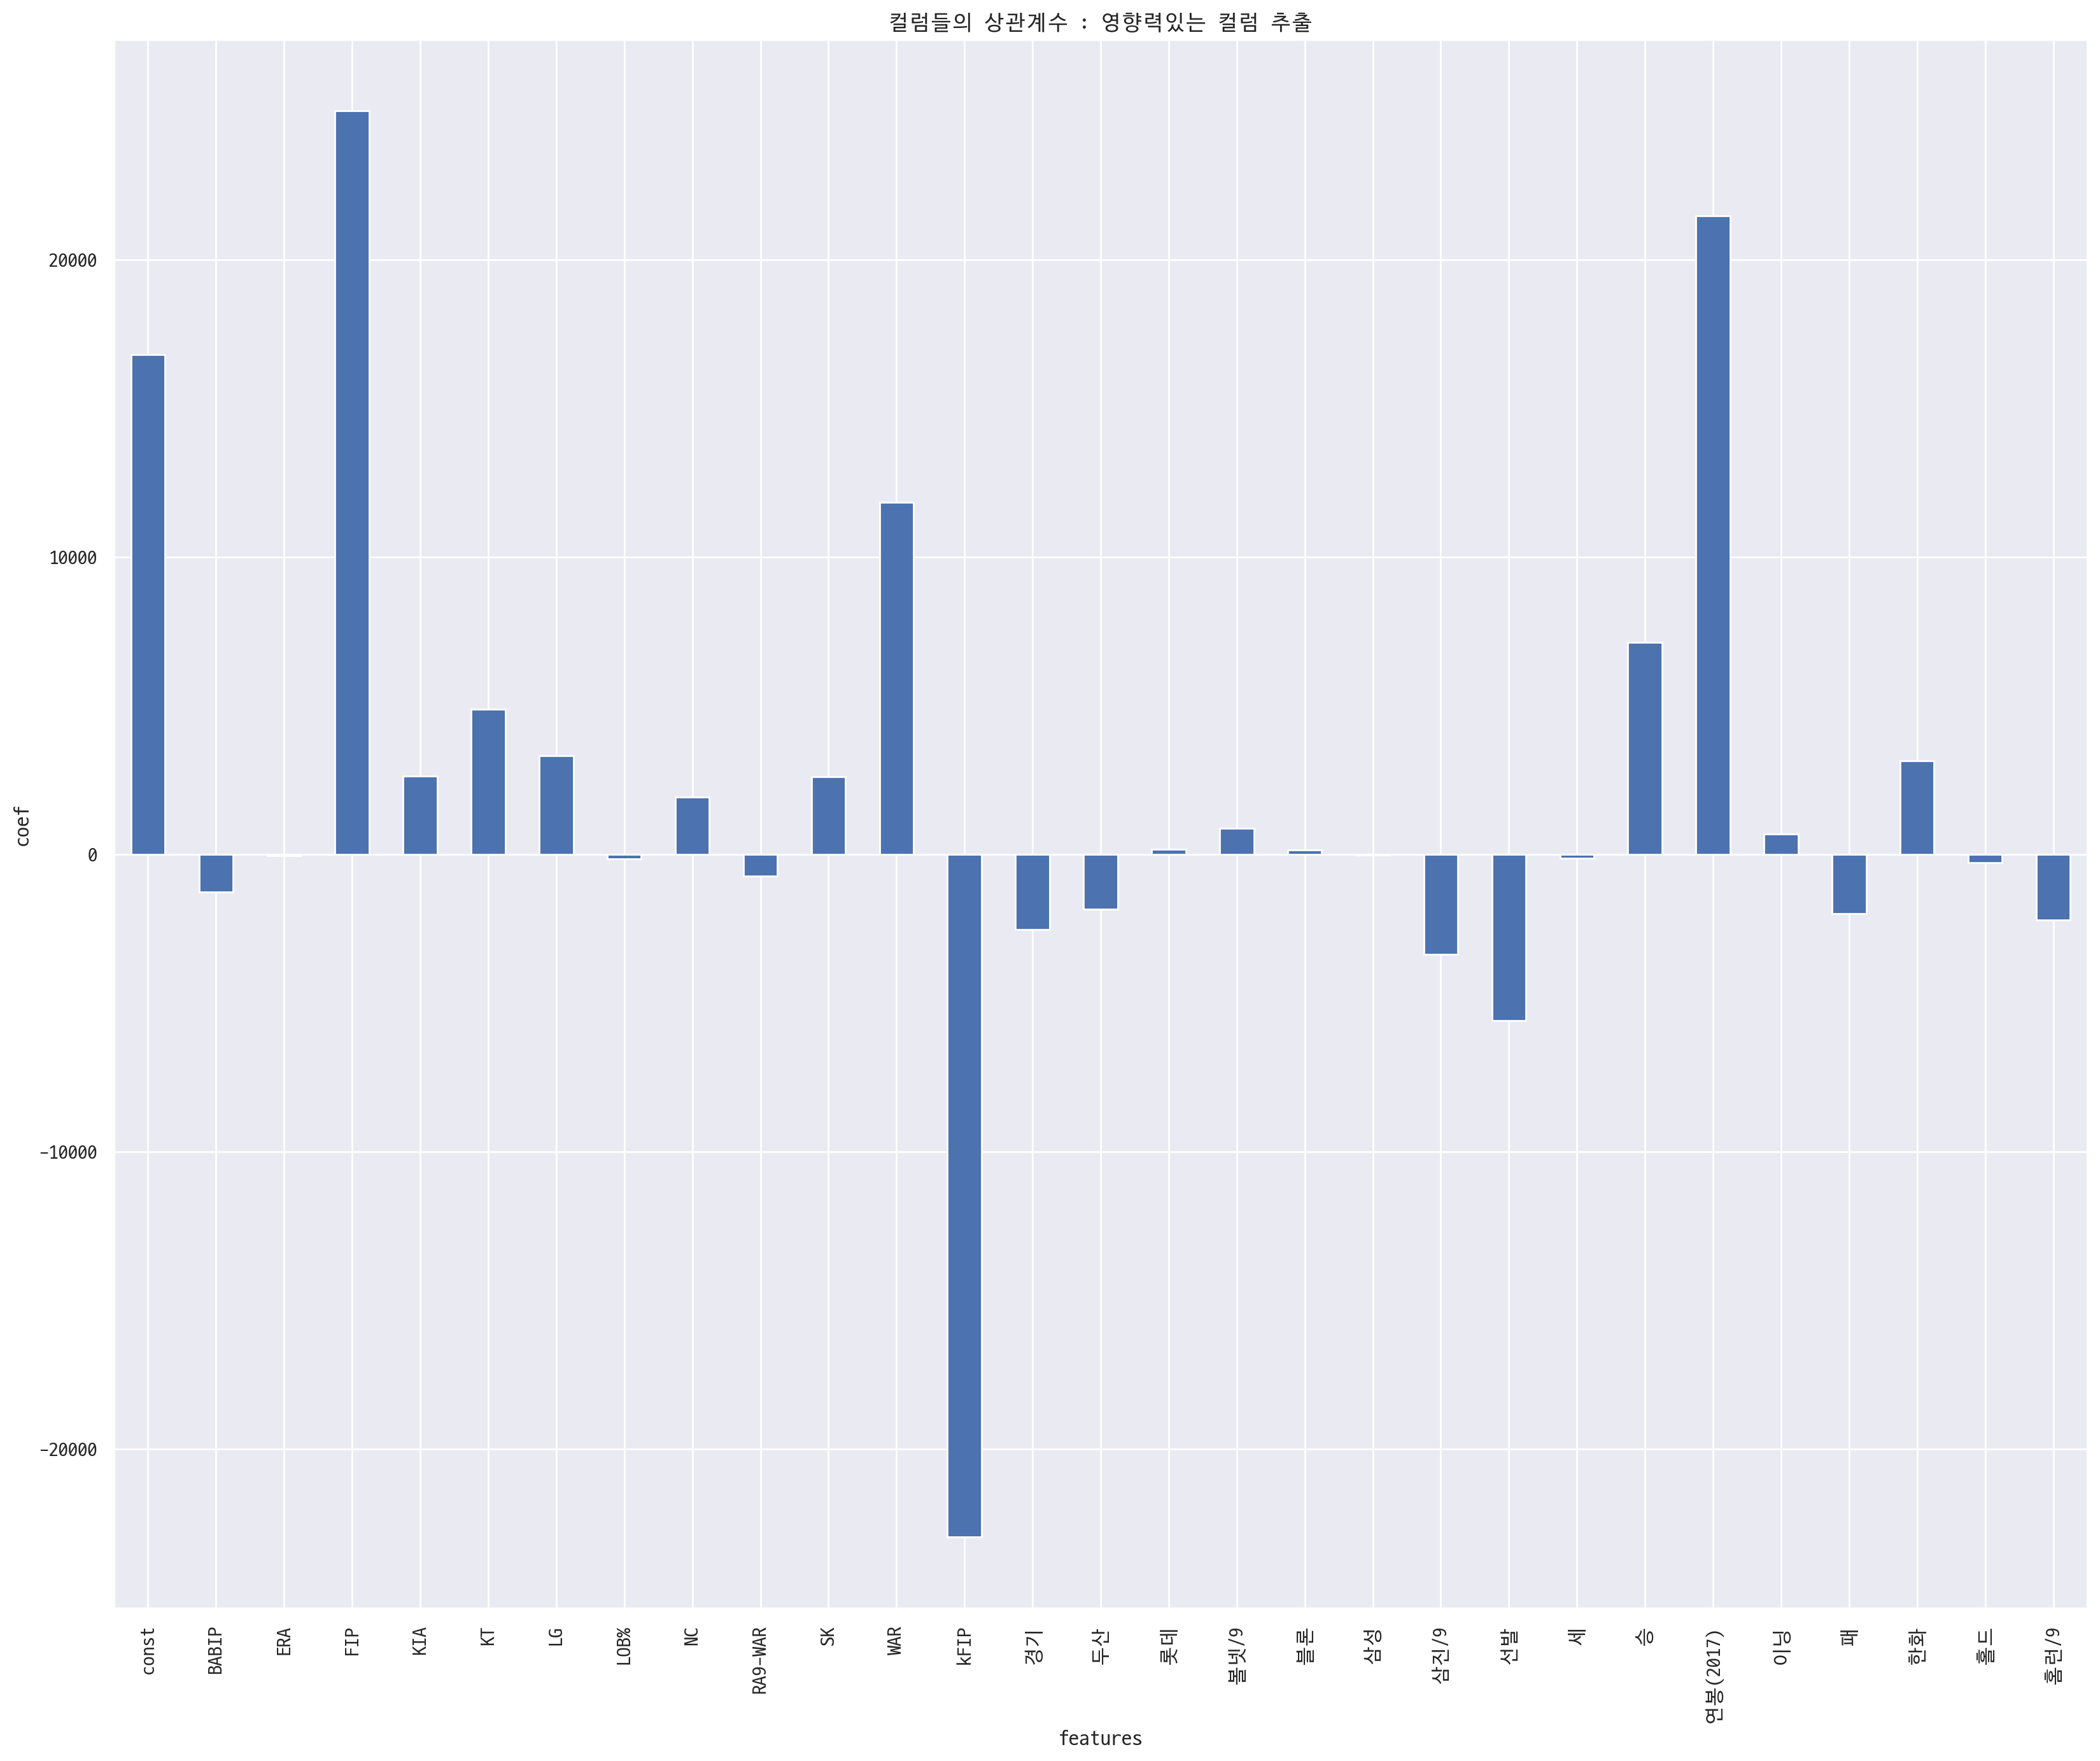

In [52]:
# 회귀 계수를 리스트로 변환하는 작업
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

# 변수명 리스트로 변환
x_labels = model.params.index.tolist()

ax = coefs_series.plot(kind='bar')
ax.set_title('컬럼들의 상관계수 : 영향력있는 컬럼 추출')
ax.set_xlabel('features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

In [55]:
picher_df[picher_df.columns.difference(['선수명', 'y'])]

,BABIP,ERA,FIP,KIA,KT,LG,LOB%,NC,RA9-WAR,SK,...,삼진/9,선발,세,승,연봉(2017),이닝,패,한화,홀드,홈런/9
0,0.016783,-0.587056,-0.971030,0,0,0,0.446615,0,3.174630,1,...,0.672099,2.452068,-0.306452,3.313623,2.734705,2.645175,1.227145,0,-0.585705,-0.442382
1,-0.241686,-0.519855,-1.061888,0,0,1,-0.122764,0,3.114968,0,...,0.134531,2.349505,-0.098502,2.019505,1.337303,2.547755,2.504721,0,-0.585705,-0.668521
2,-0.095595,-0.625456,-0.837415,1,0,0,0.308584,0,2.973948,0,...,0.109775,2.554632,-0.306452,4.348918,5.329881,2.706808,0.907751,0,-0.585705,-0.412886
3,-0.477680,-0.627856,-0.698455,0,0,1,0.558765,0,2.740722,0,...,0.350266,2.246942,-0.306452,1.760682,3.333592,2.350927,1.227145,0,-0.585705,-0.186746
4,-0.196735,-0.539055,-0.612941,0,0,0,0.481122,0,2.751570,0,...,0.155751,2.452068,-0.306452,2.537153,2.734705,2.587518,1.227145,0,-0.585705,-0.294900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.162874,0.411349,0.375810,0,0,0,-1.002712,0,-1.229537,0,...,-0.968896,-0.112010,-0.306452,-0.309907,-0.335587,0.104300,0.588357,1,-0.585705,0.363854
148,-0.871003,-0.030253,0.482702,1,0,0,-0.269422,0,-0.361721,0,...,-0.777918,0.503369,-0.306452,-0.051084,-0.535215,0.042667,-0.369825,0,-0.585705,-0.147418
149,0.466294,1.347354,1.348527,0,0,0,-1.356417,0,-1.023431,0,...,-0.756699,-0.419699,-0.306452,-0.827554,-0.020173,-0.850019,-0.369825,0,-0.585705,1.219251
150,0.005545,-0.066253,0.728554,0,0,0,0.463869,0,-0.790205,0,...,0.205264,-0.624825,-0.306452,-0.827554,-0.543201,-0.273451,-0.050431,0,-0.364245,0.226204


In [63]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_y'])
    result_df['pred_y'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_y']-result_df['pred_y'])
    print(result_df.sort_values('diff', ascending=False)[:n_tops])


get_top_error_data(y_test, pred, n_tops=10)

    real_y    pred_y     diff
10   35000   11950.0  23050.0
26   29000   46325.0  17325.0
7   100000  116831.0  16831.0
30   16000   30373.0  14373.0
28    9000   -3244.0  12244.0
13   23000   34698.0  11698.0
9    50000   39091.0  10909.0
25    4700   -5447.0  10147.0
24   45000   34979.0  10021.0
12   15000    7892.0   7108.0


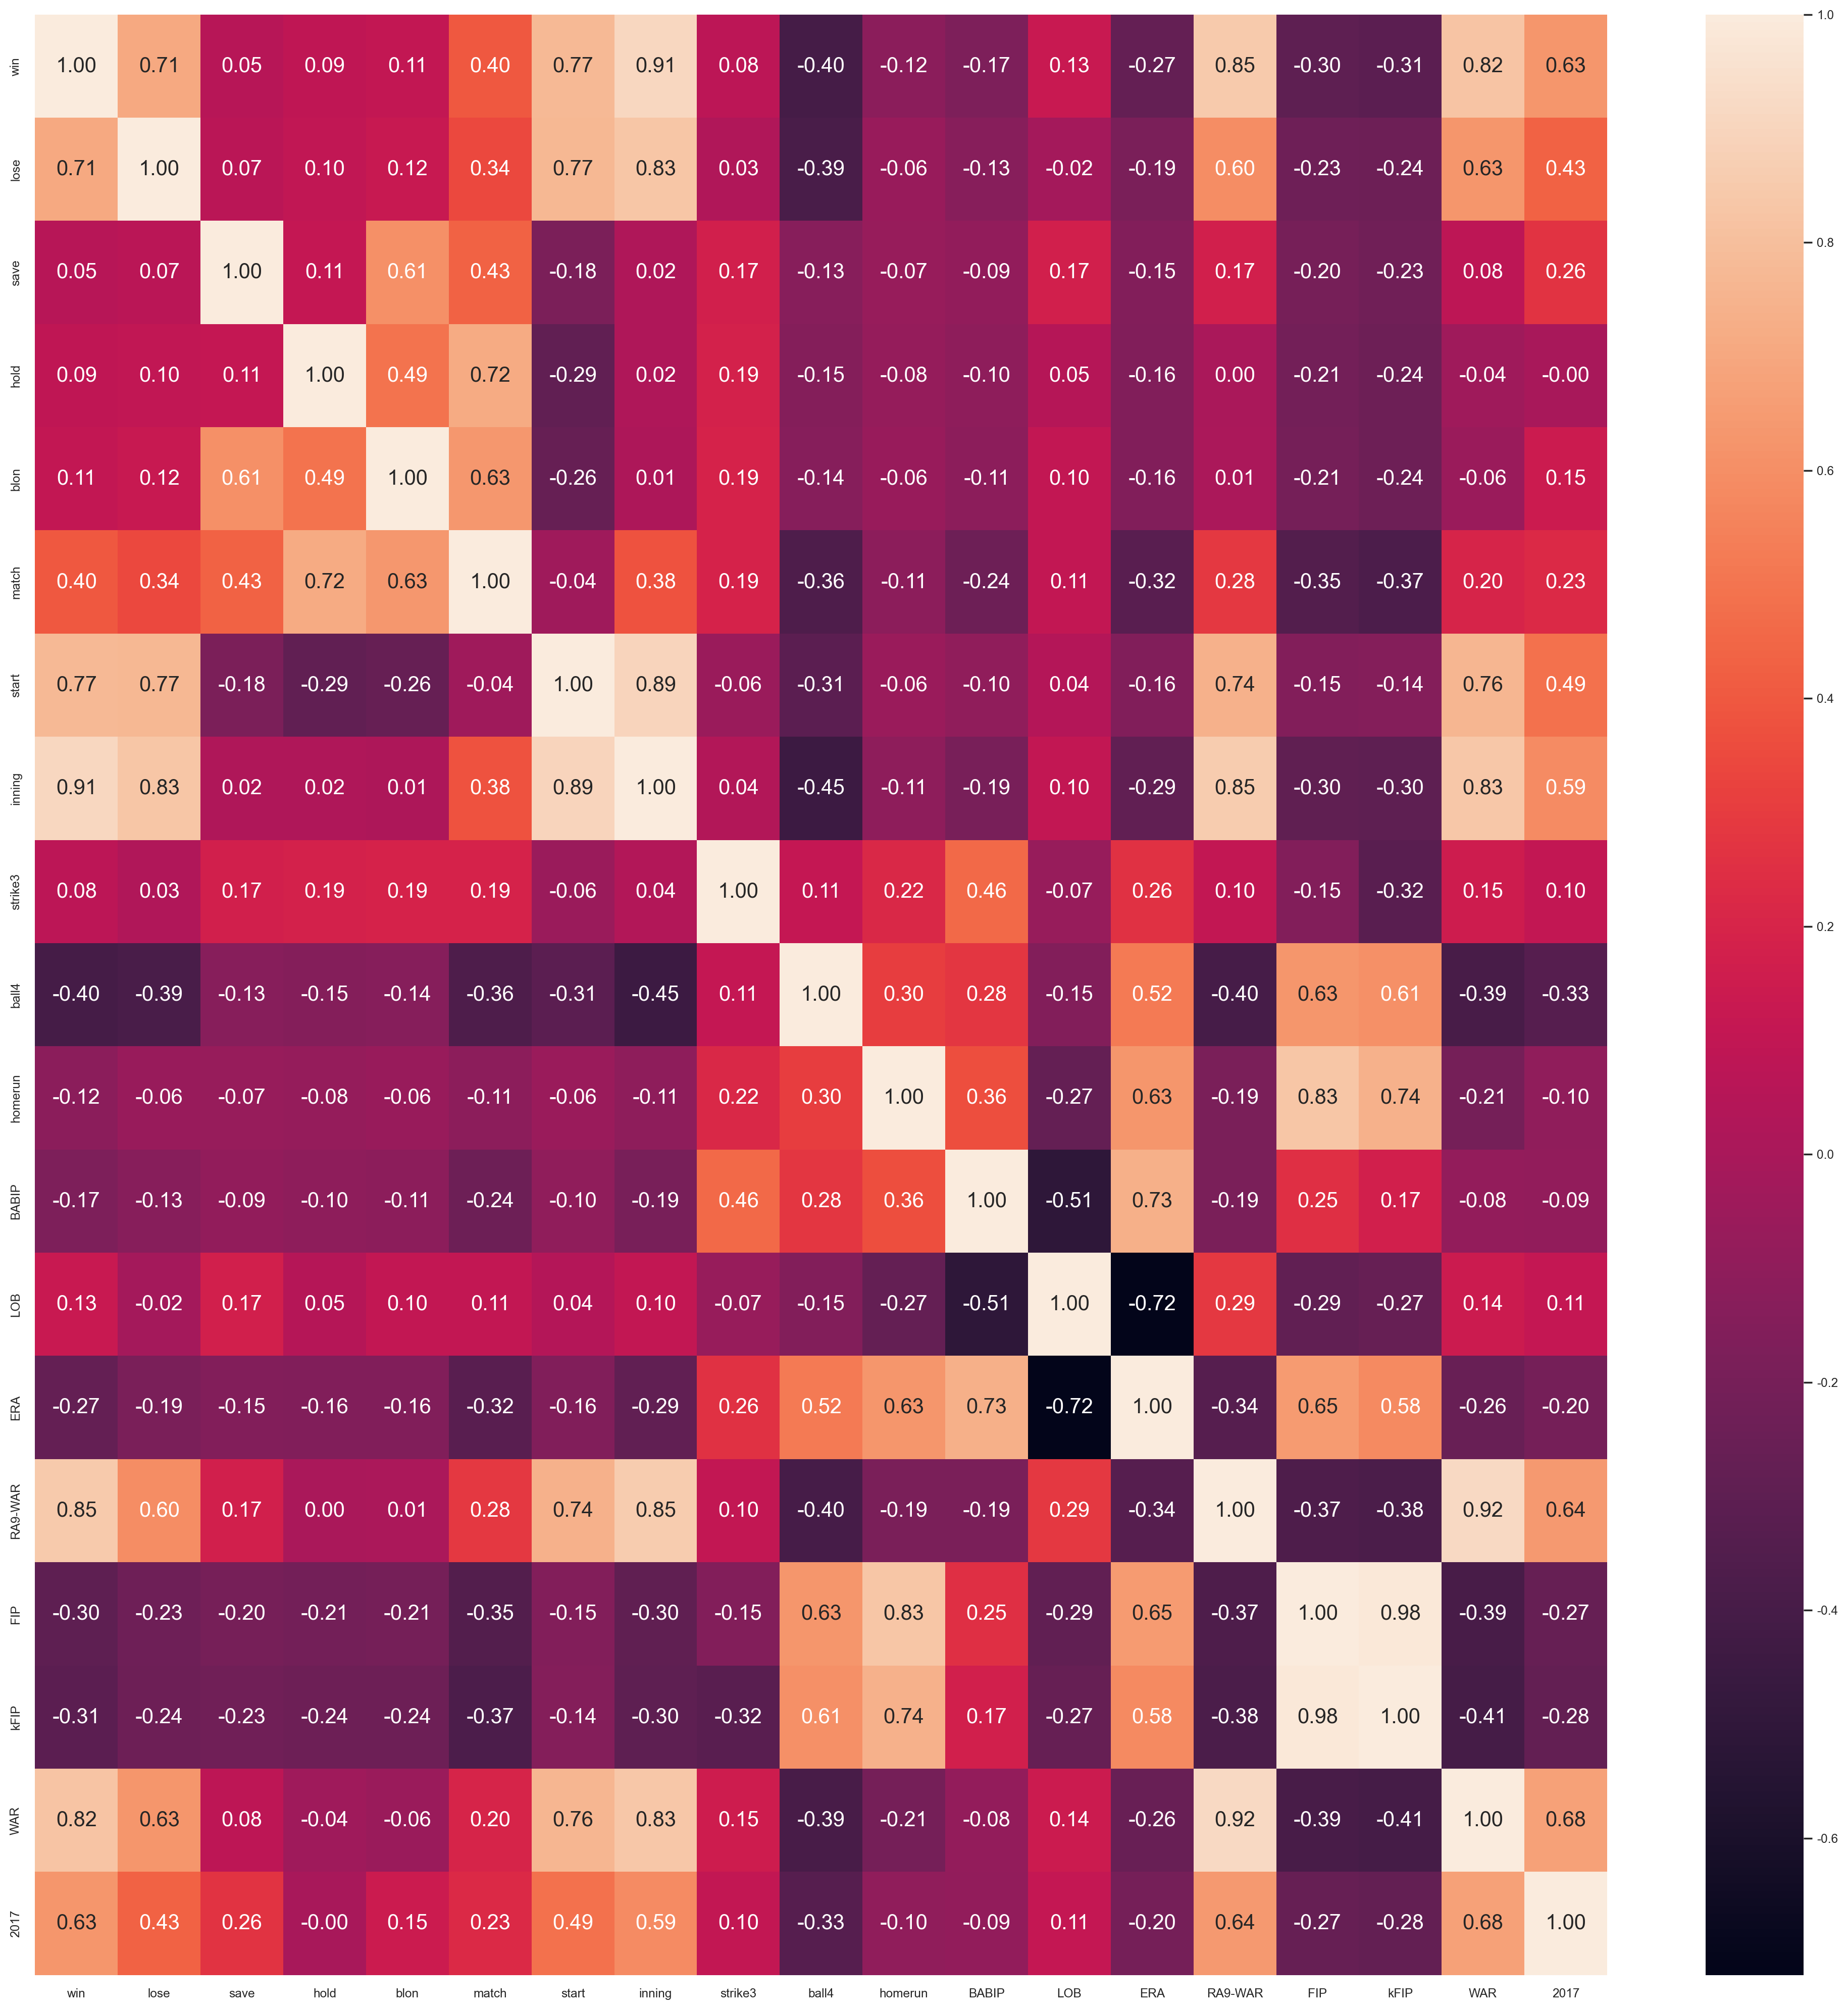

In [69]:
corr = picher_df[scale_columns].corr(method='pearson')
show_cols = ['win', 'lose', 'save', 'hold', 'blon', 'match', 'start', 'inning',
             'strike3', 'ball4', 'homerun', 'BABIP', 'LOB', 'ERA', 'RA9-WAR',
             'FIP', 'kFIP', 'WAR', '2017']

plt.figure(figsize=(20, 20))
sns.set(font_scale=0.8)
sns.heatmap(corr.values,
            annot=True,
            cbar=True,
            fmt='.2f',
            annot_kws={'size': 15},
            xticklabels=show_cols,
            yticklabels=show_cols)

plt.tight_layout()
plt.show()

## 회귀분석의 성능을 향상시키기 위해 다중공선성 확인

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  # VIF

vif = pd.DataFrame()
vif['VIF factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif.round(1)

,VIF factor,features
0,3.2,BABIP
1,10.6,ERA
2,14238.3,FIP
3,1.1,KIA
4,1.1,KT
5,1.1,LG
6,4.3,LOB%
7,1.1,NC
8,13.6,RA9-WAR
9,1.1,SK


## 적절한 피처를 이용하여 다시 모델 학습

In [77]:
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '선발', '연봉(2017)']]
y = picher_df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

lr = LinearRegression()
model = lr.fit(X_train, y_train)
pred = model.predict(X_test)

evaluate_rger(y_test, pred)

MAE : 5194.151, RMSE : 7366.828


In [78]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9212109763382361
0.8772596076714892


## 예상 연봉과 실제 연봉 비교